In [2]:
%%capture --no-stderr
%pip install -U langgraph langsmith 
%pip install -qU langchain-google-genai
!playwright install
%pip install --upgrade --quiet  playwright 
%pip install --upgrade --quiet  lxml
%pip install -U --quiet langchain-nvidia-ai-endpoints 

In [1]:
from langchain_community.tools.playwright.utils import (
    create_async_playwright_browser  # A synchronous browser is available, though it isn't compatible with jupyter.\n",	  },
)
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from playwright.async_api import async_playwright

import os
import nest_asyncio

nest_asyncio.apply()

In [2]:
from typing_extensions import TypedDict
from typing import List, Optional

class State(TypedDict):
    question: str
    index: int
    node_level: int
    main_link:str
    links: List[str]
    headers: List[str]
    elements: str
    data: str
    action: str
   

In [3]:
def return_content(x):
    return x.content

In [4]:
llm_google= ChatGoogleGenerativeAI(model="gemini-1.5-flash")
llm_nv=ChatNVIDIA(model='mistralai/mixtral-8x22b-instruct-v0.1')

prompt = ChatPromptTemplate.from_template(
    "You are an academic advisor"
    "\nYour job is to find information about research opportunities of the school that the user is in"
    "\nYou are given this link that can be your starting point:https://www.cics.umass.edu/research"
    "\nUse the navigate browser tool to go to that website"
    "\nThen you can extract text from the page to find which area is the user most interested in using the extract text tool"
    "\n\nUser question:{input}"
    "\nMake sure to only answer the area name that is on the website"
)

In [5]:
from collections import deque 
from ast import literal_eval

a=[[] for _ in range(100)]
node=1
de=deque([0])
links=["https://www.cics.umass.edu/research/research-areas"]
block=["/","/about/directory","/research/undergraduate-research-opportunities","/undergraduate-students","/about/visiting-cics","/about/people","/about","/about/contact-us","https://www.umass.edu/","/info-faculty-and-staff","/about/leadership"]
pref=["/advising",'/academics','?page','/careers','#','/news',"mailto","tel","/community","/graduate-students","/node","/about/directory?s=&field_person__profile_type_ref_target_id"]
node_levels=[0]+[None for _ in range(100)]
prefix="https://www.cics.umass.edu/"
action_list=["Idenify areas that the student want to do resarch on and don't use any links that aren't research areas","Choose the related professors that is the closest to the student's request and don't go to any links that are not links to the professors' page","Learn more about each professor and go to the LINKS section to enter their personal website. If they don't have a link to their personal website then return emtpy arrays for the link indexes and topics","Examine each professor's achievements, researches, research opportunity, and personality"]
info=[None for _ in range(100)]
headers=["Main page"]
temp_links=[]

def get_start_end(s):
    start,end=0,0
    for i in range(len(s)):
        if(s[i]=="{"):
            start=i
            break
    for i in range(len(s)-1,-1,-1):
        if(s[i]=="}"):
            end=i
            break
    return [start,end]

def parse_dict(dict):
    prompt=ChatPromptTemplate.from_template(
        "\nYou will receive a dictionary-like string that is generated by an llm"
        "\nThe dictionary seems to have a syntax error that prevents it from being parsed correctly"
        "\nYour job is to make small adjustments to fix the error so the string can be parsed into a dictionary"
        "\nThe string:{content}"
        "\nDon't add any comments, only return the string after adjustments"
    ) 
    chain=prompt | llm_google | return_content
    ans=get_start_end(dict)
    start,end=ans[0],ans[1]
    try: 
        result=literal_eval(dict[start:end+1])
    except:
        fix=chain.invoke(dict[start:end+1])
        ans=get_start_end(fix)
        start,end=ans[0],ans[1]
        result=literal_eval(fix[start:end+1])
    links=result["link_indexes"]
    topics=result["topics"]
    if(len(links)>len(topics)):
        links=links[:len(topics)+1]
    else:
        topics=topics[:len(links)+1]
    if(len(links)>2):
        links=links[:2]
        topics=topics[:2]
    if "description" in result:
        return{
            "link_indexes":links,
            "topics":topics,
            "description":result["description"]
        }
    else:
        return {
            "link_indexes":links,
            "topics":topics
        }

def check_link(link):
    for x in links:
        if(link==x):
            return False
    for x in block:
        if(link==x):
            return False
    for x in pref:
        if(link[:len(x)]==x):
            return False
    return True

def router(state):
    main_link=""
    print(len(links))
    if(state["links"]!=None):
        num=len(links)
        for i in range(len(state["links"])):
            links.append(temp_links[state["links"][i]])
            a[state['index']].append(num+i)
            node_levels[num+i]=node_levels[state['index']]+1
            de.append(num+i)
            headers.append(state["headers"][i])
        print(node_levels[:len(links)])
    if(state["data"]!=None):
        info[state['index']] = state['data']
    flag=0
    while flag==0:
        print("loop")
        global node
        if len(de)>0:
            index=de[-1]
            de.pop()
            main_link=links[index]
            node_level=node_levels[index]
            if(node_level>3):
                node+=1
                continue
            else: 
                node+=1
                node_levels[index]=node_level
                action=action_list[node_level]
                flag=1
                print(main_link)
                print(node_levels[index])
                print(action)
        else:
            flag=1
            index=None
            action=None
    
    return {
        "index":index,
        "main_link":main_link,
        "node_level":node_level,
        "links":None,
        "data":None,
        "headers":None,
        "elements":None,
        "question":state["question"],
        "action":action
    }

async def extract_page(state):
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()

        # Navigate to the webpage
        try:
            await page.goto(state["main_link"])
        except: 
            await page.goto(prefix + state["main_link"])

        elements = await page.query_selector_all('h1, h2, p, a')

        result=""
        global temp_links
        temp_links.clear()
        num=0
        for index, element in enumerate(elements, start=1):
            tag_name = await element.evaluate("el => el.tagName")
            text = await element.inner_text()  
            if(tag_name!='A'):
                result+=f"\n{text} "
            if(tag_name=='A' and text!=""):
                link= await element.get_attribute('href')
                if(link==None):
                    continue
                if(len(link)>0 and check_link(link)==False):
                    continue
                result+=f"\n{text}. Link_index:{num} "
                temp_links.append(link)
                num+=1
        if(result==''):
            result=None 
        else:
            if(len(result)>500):
                result=result[200:-200]
        await browser.close()
        return {
            "index":state["index"],
            "main_link":state["main_link"],
            "node_level":state["node_level"],
            "links":None,
            "data":None,
            "headers":None,
            "elements":result,
            "question":state["question"],
            "action":state["action"]
        }

def process(state):
    proc_prompt=ChatPromptTemplate.from_template(
        "You are an academic advisor"
        "\nYou will receive information of all the elements of the current website"
        "\nYou need to help with a student's request by filtering out unnecessary links or content that is not related to both the student's request and perfoming the given action"
        "\nDon't include anything that's related to research organizations and not relevant to the action"
        "\nKeep the link indexes related to the elements that you are keeping and don't alter the elements and link indexes in any way. Put the link indexes right after the content that they represent"
        "\nElements:{elements}"
        "\nStudent's request:{input}"
        "\nAction:{action}"
        "\nYour answer should be shorter and more focused than the initial contents of all the elements"
    )
    proc = proc_prompt | llm_nv | return_content
    trim = proc.invoke({"elements":state["elements"], "input":state["question"],"action":state["action"]})
    return {
        "index":state["index"],
        "main_link":state["main_link"],
        "node_level":state["node_level"],
        "links":None,
        "data": None,
        "headers":None,
        "elements": trim,
        "question":state["question"],
        "action":state["action"]
    }
    

def scan(state):
    prompt = ChatPromptTemplate.from_template(
        "You are an academic advisor"
        "\nYour job is to perform the action given with all the content of elements of the website to help with the student's request"
        "\nYou will need to return thorough description of the main content of the page, hyperlinks that may contain materials strictly related to the student's request and the given action, and a topic name with at most 3 words for those links"
        "\nAction:{action}"
        "\nElements:{element}"
        "\nStudent's request:{input}"
        '\nYour answer have to be in the format: {{"description":"content", "link_indexes":[link_index_1,link_index_2,..],"topics":[topic_1,topic_2,..]}}'
        "\nThey must all relate to the action and student's request and they must all be different link_indexes "
        "\nThe link indexes should match with the headers"
        "\nIf the there is no links that is strictly related to the student's request or they are too advanced then return emtpy array for the link indexes and topics part of your answer"
        "\nRemember your answer must be in the format of a dictionary that can be parse and contain no additional comments"
        )
    chain = prompt | llm_nv | return_content | parse_dict
    answer = chain.invoke({"element":state["elements"], "input":state["question"], "action":state["action"]})
    links=answer["link_indexes"]
    headers=answer["topics"]
    data=answer["description"]
    return{
        "index":state["index"],
        "main_link":state["main_link"],
        "node_level":state["node_level"],
        "links":links,
        "data":data,
        "headers":headers,
        "elements": state["elements"],
        "question":state["question"],
        "action":state["action"]
    }

In [6]:
from langgraph.graph import END, START, StateGraph

def end_condition(state):
    if(node>20):
        return END
    if(state["index"]==None):
        return END 
    else:
        return "extract_page"

graph_builder = StateGraph(State)

graph_builder.add_node("router",router)
graph_builder.add_edge(START, "router")


graph_builder.add_node("extract_page",extract_page)
graph_builder.add_conditional_edges("router",end_condition,{"extract_page":"extract_page",END:END})

graph_builder.add_node("process",process)
graph_builder.add_edge("extract_page","process")

graph_builder.add_node("scan",scan)
graph_builder.add_edge("process","scan")

graph_builder.add_edge("scan","router")

graph = graph_builder.compile()



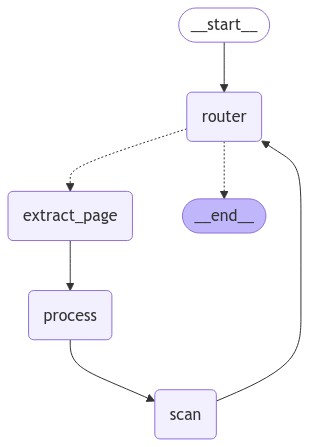

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [8]:
async def main(message):
    events = graph.astream({
        "question": message,
        "index": 0,
        "main_link":None,
        "node_level":None,
        "links": None,
        "headers": None,
        "elements": None,
        "data": None,
        "action": None
    },{"recursion_limit": 50})
    async for event in events:
        print(event)


In [ ]:
%pip install fastapi uvicorn nest_asyncio pyngrok
%pip install python-multipart
!ngrok config add-authtoken 2odRgcRheiPYg1nSWLjvQk8LsrT_4KM3atzh4fxHzcb6ACscG

from fastapi import FastAPI,Form
import nest_asyncio
import uvicorn
from pyngrok import ngrok
from typing import Annotated


app = FastAPI()

def reset():
    global a
    global node 
    global de
    global links
    global block
    global pref
    global node_levels
    global prefix
    global action_list
    global info
    global headers
    global temp_links 
    a=[[] for _ in range(100)]
    node=1
    de=deque([0])
    links=["https://www.cics.umass.edu/research/research-areas"]
    block=["/","/about/directory","/research/undergraduate-research-opportunities","/undergraduate-students","/about/visiting-cics","/about/people","/about","/about/contact-us","https://www.umass.edu/","/info-faculty-and-staff","/about/leadership"]
    pref=["/advising",'/academics','?page','/careers','#','/news',"mailto","tel","/community","/graduate-students","/node","/about/directory?s=&field_person__profile_type_ref_target_id"]
    node_levels=[0]+[None for _ in range(100)]
    prefix="https://www.cics.umass.edu/"
    action_list=["Idenify areas that the student want to do resarch on and don't use any links that aren't research areas","Choose the related professors that is the closest to the student's request and don't go to any links that are not links to the professors' page","Learn more about each professor and go to the LINKS section to enter their personal website. If they don't have a link to their personal website then return emtpy arrays for the link indexes and topics","Examine each professor's achievements, researches, research opportunity, and personality"]
    info=[None for _ in range(100)]
    headers=["Main page"]
    temp_links=[]

@app.post("/research/")
async def submit(prompt: Annotated[str, Form()]):
    reset()
    await main(prompt)
    for i in range(len(links)):
        if(links[i][:4]!="http"):
            links[i]=prefix+links[i]
    return{
        "adj":a,
        "header":headers,
        "info":info,
        "links":links
    }

ngrok_tunnel = ngrok.connect(8000)
print(f"ngrok public URL: {ngrok_tunnel.public_url}")

nest_asyncio.apply()

uvicorn.run(app, port=8000)



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Authtoken saved to configuration file: C:\Users\PC\AppData\Local/ngrok/ngrok.yml


INFO:     Started server process [20528]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


ngrok public URL: https://2d5e-128-119-202-7.ngrok-free.app
INFO:     128.119.202.19:0 - "GET /research HTTP/1.1" 307 Temporary Redirect
INFO:     128.119.202.19:0 - "GET /research/ HTTP/1.1" 405 Method Not Allowed
INFO:     128.119.202.19:0 - "GET /favicon.ico HTTP/1.1" 404 Not Found
1
loop
https://www.cics.umass.edu/research/research-areas
0
Idenify areas that the student want to do resarch on and don't use any links that aren't research areas
{'router': {'question': 'I want to learn about AI', 'index': 0, 'node_level': 0, 'main_link': 'https://www.cics.umass.edu/research/research-areas', 'links': None, 'headers': None, 'elements': None, 'data': None, 'action': "Idenify areas that the student want to do resarch on and don't use any links that aren't research areas"}}
{'extract_page': {'question': 'I want to learn about AI', 'index': 0, 'node_level': 0, 'main_link': 'https://www.cics.umass.edu/research/research-areas', 'links': None, 'headers': None, 'elements': 'chievements. Link_ind